In [1]:
%matplotlib notebook

import tkinter
import matplotlib
import platform
if platform.system() not in ['Linux', 'Darwin'] and not platform.system().startswith('CYGWIN'):
    matplotlib.use('TKAgg')
import matplotlib.pyplot as plt
from IPython import display


# 漢字識別 (pytorch)

![Alt text](../images/hanzi.jpg)

## 從錯誤率90幾%到正確率90幾%之路

In [2]:
import glob
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *

trident 0.3.5
Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Using pillow image backend.
Pillow version:6.2.1.
Pytorch version:1.3.1.


In [3]:
dataset=T.load_examples_data('hanzi')
dataset.image_transform_funcs=[
            to_rgb(),
            resize((112,112),True),
            normalize(0, 255),  
            normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
dataset.minibatch_size=8

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
Mapping data  in train scenario  success, total 40000 record addeds.
Mapping label  in train scenario  success, total 40000 records added.
Mapping class_names  in en-us   success, total 100 class names added.
Mapping data  in train scenario  success, total 10001 record addeds.
Mapping label  in train scenario  success, total 10001 records added.
Mapping class_names  in en-us   success, total 100 class names added.


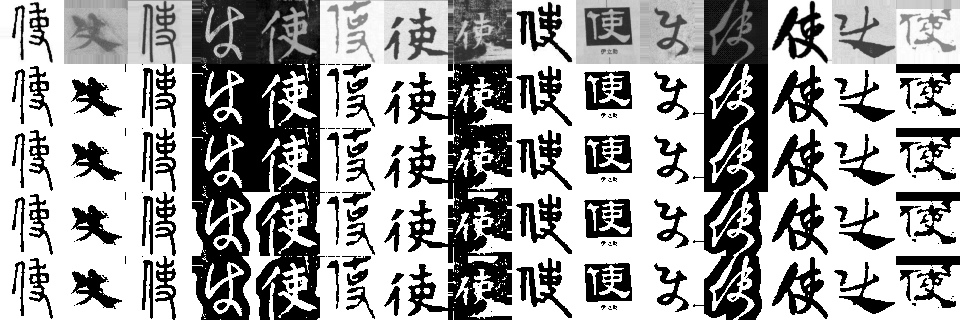

In [4]:
def test_image_binarization(*test_funcs, topk=15):
    result = dataset.get_all_data(is_shuffle=False, topk=3800)[3780:3780+topk]#從原始數據中取15個字
    resize_fn = resize((64, 64), True)
    before = []
    after = OrderedDict()
    after_img=[]
    for i in range(topk):
        fnc_result=[]
        gray_result = resize_fn(gray_scale()(result[i]))#取灰階後縮放至(64,64)
        fnc_result.append(gray_result.copy())
    
        for j in range(len(test_funcs)):#每一種二值化技術分別處理一次
            func=test_funcs[j]
            gray_result=func(gray_result)
            fnc_result.append(gray_result.copy())
        after_img.append(np.concatenate(fnc_result, axis=0))
        
           
    merge = np.concatenate(after_img, axis=1)

    return array2image(merge)

    

test_image_binarization(
adaptive_binarization('otsu'),
adaptive_binarization('minimum'),
adaptive_binarization('local'),
adaptive_binarization('isodata'))



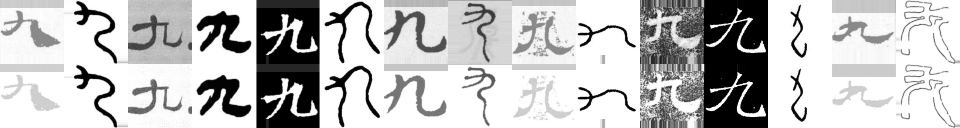

In [5]:
#
def test_image(*test_funcs, topk=15):
    result = dataset.get_all_data(is_shuffle=False, topk=1500)[1480:1480+topk]
    resize_fn = resize((64, 64), True)
    before = []
    after = []
    for i in range(topk):
        gray_result = gray_scale()(result[i])
        before.append(to_rgb()(resize_fn(gray_result.copy())))
    
        for fn in test_funcs:
            gray_result=fn(gray_result)
        after.append(to_rgb()(resize_fn(gray_result)))
    before = np.concatenate(before, axis=1)
    after = np.concatenate(after, axis=1)
    merge = np.concatenate([before, after], axis=0)
    merge = array2image(merge)
    return merge

    

test_image(
     adjust_contast(1.5))

C:\Anaconda3\envs\azuremlenv\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


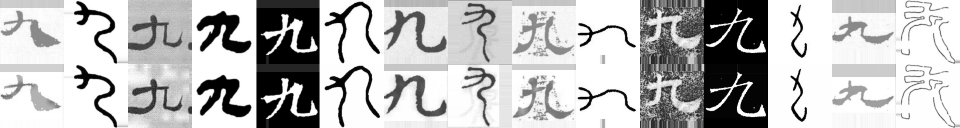

In [6]:
test_image(
     clahe(clip_limit=0.02,nbins=64))

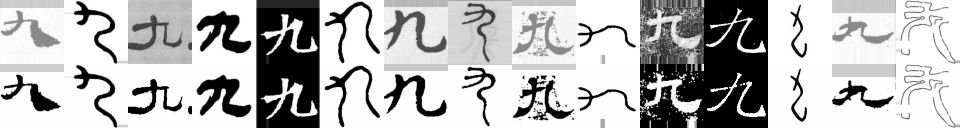

In [7]:
test_image( 
            adaptive_binarization(),
            clahe(clip_limit=0.02,nbins=64),
            erosion_then_dilation(filter_size=3,repeat=5),
            adaptive_binarization(),
            auto_level()
           )

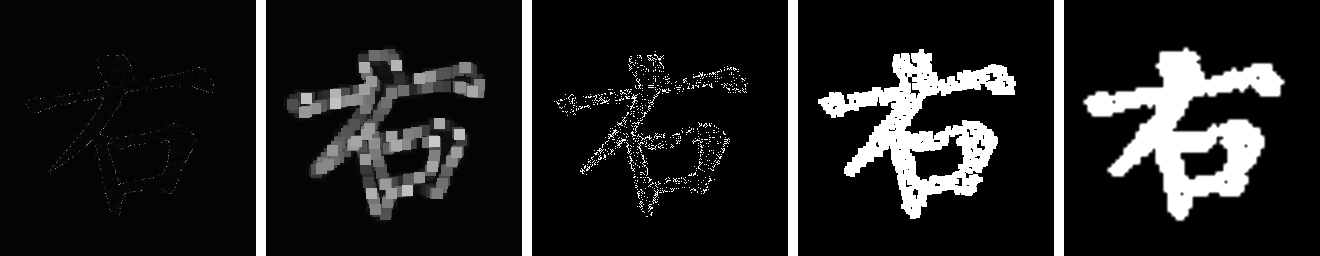

In [8]:
#原圖
img=resize((256, 256), True)(image2array('../images/yo.jpg'))
#填充
img1= image_dilation(filter_size=3,repeat=5)(img)
split=np.ones((img.shape[0],10))*255
#isodata二值化
img2=adaptive_binarization('isodata')(img)
#將img2再填充
img3=image_dilation(filter_size=3,repeat=2)(img2)

#將img3縮小後進行otsu二值化後放大回原尺寸
img4=adjust_contast(1.5)(resize((256, 256), True)(adaptive_binarization('otsu')(resize((64, 64), True)(img3))))
img=array2image(np.concatenate([img,split, img1,split,img2,split,img3,split,img4], axis=1))

img

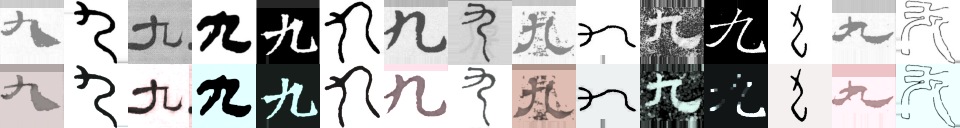

In [9]:
test_image(erosion_then_dilation(filter_size=5,repeat=5),
           clahe(clip_limit=0.02,nbins=64),
           auto_level(),
           to_rgb(),
           random_adjust_hue()
           )

![Alt text](../images/densenet.png)

In [10]:
resnet50=ResNet50(include_top=True,
             pretrained=True,
             input_shape=(3, 112, 112),
             classes=100)
resnet50.model.trainable=False
resnet50.model.fc.trainable=True
resnet50.model.layer4.trainable=True



#densenet因為不是預訓練模型，當然也不用透過設定trainable來控制那些權重開放學習
densenet =DenseNet([5, 8,10,6],16,32, include_top=True, pretrained=False,input_shape=(3,112,112), num_classes=100,name='densenet121')



archive file is already existing, donnot need download again.
23712932 parameters have set untrainable
204900 parameters have set trainable
14964736 parameters have set trainable
---分隔線----


In [11]:

dataset.image_transform_funcs=[
    adaptive_binarization(),
    clahe(clip_limit=0.02, nbins=64),
    erosion_then_dilation(filter_size=3,repeat=3),
    auto_level(),
    adaptive_binarization(),
    random_invert_color(),
    to_rgb(),
    random_adjust_hue(),
    random_center_crop(112,112,scale=(0.9,1.1)),
    normalize(0, 255),  
    normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
#自適應二值化
#clahe
#先腐蝕後填充
#自動色階
#自適應二值化
#隨機黑白翻轉
#轉rgb
#隨機調整色相
#隨機縮放取中心點切出112,112大小
#除以255
#基於imagenet平均值與標準差進行標準化

In [12]:
resnet50=resnet50\
    .with_optimizer(optimizer='Adam',lr=5e-4,betas=(0.9, 0.999))\
    .with_loss(CrossEntropyLoss)\
    .with_metric(accuracy,name='accuracy')\
    .with_metric(accuracy,topk=3,name='top3_accuracy')\
    .with_regularizer('l2')\
    .with_constraint('max_min_norm')\
    .with_model_save_path('Models/hanzi_resnet50.pth')\
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='accuracy',mode='max',factor=0.75,patience=5,cooldown=1,threshold=5e-5,warmup=0)
resnet50.summary()


--------------------------------------------------------------------------------------------------------------------------------
                            Layer (type)                   Output Shape                    Weight Shape      Bias Shape          Param #          FLOPS #
                             first_block             [-1, 64, 112, 112]                                                                0              0.0
                            batch_norm_1             [-1, 64, 112, 112]                            [64]            [64]              128      2,395,904.0
                            max_pool2d_1               [-1, 64, 56, 56]                                                                0              0.0
                         layer1.0_0_conv               [-1, 64, 56, 56]                                                                0              0.0
                            batch_norm_3               [-1, 64, 56, 56]                            [6

In [13]:


densenet=densenet\
    .with_optimizer(optimizer='Ranger',lr=2e-3,betas=(0.9, 0.999))\
    .with_loss(CrossEntropyLoss)\
    .with_metric(accuracy,name='accuracy')\
    .with_metric(accuracy,topk=3,name='top3_accuracy')\
    .with_regularizer('l2')\
    .with_constraint('max_min_norm')\
    .with_model_save_path('Models/hanzi_densenet.pth')\
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='accuracy',mode='max',factor=0.75,patience=5,cooldown=1,threshold=5e-5,warmup=0)
densenet.summary()


--------------------------------------------------------------------------------------------------------------------------------
                            Layer (type)                   Output Shape                    Weight Shape      Bias Shape          Param #          FLOPS #
                              conv1/conv               [-1, 32, 56, 56]                                                                0              0.0
                           batch_norm_54               [-1, 32, 56, 56]                            [32]            [32]               64        297,920.0
                            max_pool2d_8               [-1, 32, 28, 28]                                                                0              0.0
                           batch_norm_55               [-1, 32, 28, 28]                            [32]            [32]               64         74,480.0
                                  relu_1               [-1, 32, 28, 28]                              

Total params: 604,064
Trainable params: 604,064
Non-trainable params: 0
Total MACC: 109,296,514.0
Total FLOPs: 0.21981 GFLOPs
----------------------------------------------------------------
Input size (MB): 0.14
Forward/backward pass size (MB): 26.07
Params size (MB): 2.30
Estimated Total Size (MB): 28.52
----------------------------------------------------------------


In [14]:
plan=TrainingPlan()\
    .add_training_item(resnet50,name='baseline')\
    .add_training_item(densenet,name='challenger')\
    .with_data_loader(dataset)\
    .repeat_epochs(7)\
    .within_minibatch_size(32)\
    .print_progress_scheduling(20,unit='batch')\
    .display_loss_metric_curve_scheduling(frequency=200,unit='batch',imshow=True)\
    .save_model_scheduling(100,unit='batch')

baseline         Step: 56s698ms | Loss: 4.085   | Accuracy: 54.688% ,Top3Accuracy: 57.969%  | learning rate: 1.188e-05 | epoch: 7 ( 60/1250 )
challenger       Step: 315ms    | Loss: 0.336   | Accuracy: 95.938% ,Top3Accuracy: 98.750%  | learning rate: 1.125e-03 | epoch: 7 ( 60/1250 )
baseline         Step: 1m944ms  | Loss: 4.036   | Accuracy: 60.000% ,Top3Accuracy: 61.875%  | learning rate: 1.188e-05 | epoch: 7 ( 80/1250 )
challenger       Step: 266ms    | Loss: 0.398   | Accuracy: 95.469% ,Top3Accuracy: 97.812%  | learning rate: 1.125e-03 | epoch: 7 ( 80/1250 )
baseline         Step: 57s786ms | Loss: 4.065   | Accuracy: 57.500% ,Top3Accuracy: 60.312%  | learning rate: 1.188e-05 | epoch: 7 ( 100/1250 )
challenger       Step: 267ms    | Loss: 0.323   | Accuracy: 96.875% ,Top3Accuracy: 97.812%  | learning rate: 1.125e-03 | epoch: 7 ( 100/1250 )
baseline         Step: 55s275ms | Loss: 4.078   | Accuracy: 55.469% ,Top3Accuracy: 59.062%  | learning rate: 1.188e-05 | epoch: 7 ( 120/1250 )
cha

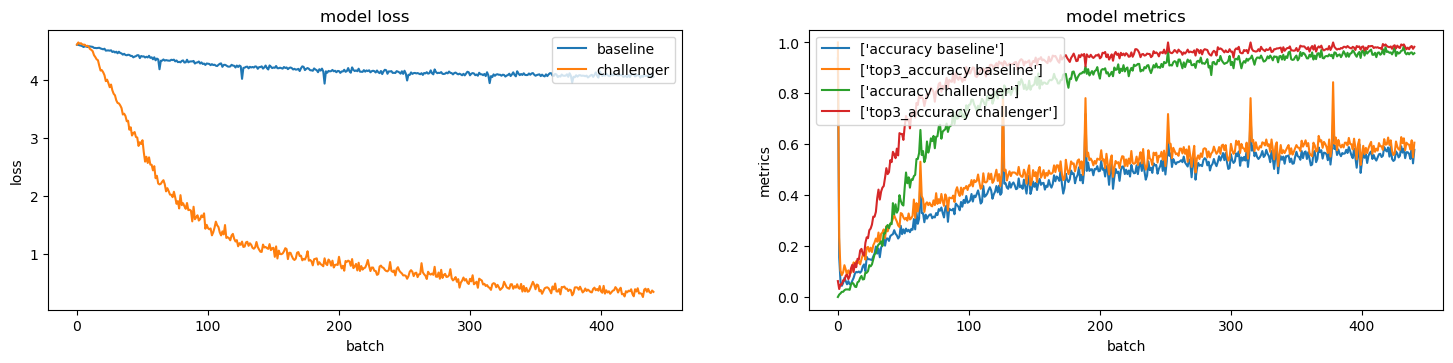

baseline         Step: 53s651ms | Loss: 4.071   | Accuracy: 56.250% ,Top3Accuracy: 59.688%  | learning rate: 1.188e-05 | epoch: 7 ( 220/1250 )
challenger       Step: 279ms    | Loss: 0.370   | Accuracy: 95.781% ,Top3Accuracy: 98.750%  | learning rate: 1.125e-03 | epoch: 7 ( 220/1250 )
threshold_otsu is expected to work with images having more than one color. The input image seems to have just one color 0.0.
baseline         Step: 53s147ms | Loss: 4.040   | Accuracy: 59.219% ,Top3Accuracy: 62.500%  | learning rate: 1.188e-05 | epoch: 7 ( 240/1250 )
challenger       Step: 330ms    | Loss: 0.317   | Accuracy: 96.250% ,Top3Accuracy: 98.281%  | learning rate: 1.125e-03 | epoch: 7 ( 240/1250 )


In [ ]:
plan.start_now()
print('')

In [14]:
#您也可以使用我這邊訓練過的預訓練模型
#densenet.load_model('Models/hanzi_densenet.pth.tar')

#記得要把類別代碼class_names設定完，我們才有辦法使用infer_single_image功能
#類別代碼可以直接從Data Provider取得

print(dataset.class_names)
densenet.class_names=dataset.class_names['en-us']

{'en-us': ['且', '世', '东', '九', '亭', '今', '从', '令', '作', '使', '侯', '元', '光', '利', '印', '去', '受', '右', '司', '合', '名', '周', '命', '和', '唯', '堂', '士', '多', '夜', '奉', '女', '好', '始', '字', '孝', '守', '宗', '官', '定', '宜', '室', '家', '寒', '左', '常', '建', '徐', '御', '必', '思', '意', '我', '敬', '新', '易', '春', '更', '朝', '李', '来', '林', '正', '武', '氏', '永', '流', '海', '深', '清', '游', '父', '物', '玉', '用', '申', '白', '皇', '益', '福', '秋', '立', '章', '老', '臣', '良', '莫', '虎', '衣', '西', '起', '足', '身', '通', '遂', '重', '陵', '雨', '高', '黄', '鼎']}


In [15]:
#使用infer_single_image兩個要件
#第一個是要設定正確的分類代碼class_names
#第二個是要在preprocess_flow清單中列出圖片送去推論前的所有處理步驟
#由於目前是要做推論而非建模，因此需要調整一下內容
#就不需要隨機的數據增強

densenet.preprocess_flow=[
    adaptive_binarization(),
    clahe(clip_limit=0.02, nbins=64),
    erosion_then_dilation(filter_size=3,repeat=3),
    auto_level(),
    adaptive_binarization(),
    to_rgb(),
    resize((112,112),True),
    normalize(0, 255),  
    normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
#自適應二值化
#Clahe
#腐蝕/填充
#自動色階
#再做一次自適應二值化
#轉RGB
#依照原比例縮放至112
#除以255
#依照imagenet均值與標準差正規化

In [ ]:

#列印出train數據長度，以及batch_sampler可以計算的批次數
print(len(dataset),len(dataset.traindata))


#切換目前場景為test
dataset.current_scenario='test'
#暫時清空image_transform_funcs，因為等下要供給圖檔給densenet做推論，那邊已經有數據處理流程，因此不需要做兩次工
dataset.image_transform_funcs=[]
#列印出數據長度，以及batch_sampler可以計算的批次數
print(len(dataset),len(dataset.batch_sampler))

預測: OrderedDict([('多', (27, 0.8758861)), ('令', (7, 0.041870225)), ('足', (90, 0.037311263))]) 答案: 多


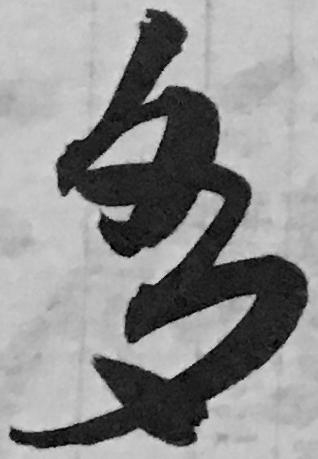

In [28]:
data,label=dataset.next()

print('預測:',densenet.infer_single_image(data.copy()[0],3),'答案:',densenet.class_names[label[0]])

array2image(data[0])